<div style="text-align: left">
<img src="http://project.inria.fr/saclaycds/files/2017/02/logoUPSayPlusCDS_990.png" width="800px">
</div>

# [RAMP](https://www.ramp.studio/problems/storm_forecast_hackathon) on Tropical Storm Intensity Forecast (from reanalysis data)

_Sophie Giffard-Roisin (CU/CNRS), Mo Yang (CNRS), Balazs Kegl (CNRS/CDS), Claire Monteleoni (CU/CNRS), Alexandre Boucaud (CNRS/CDS)_

1. [Introduction](#Introduction)
2. [The prediction task](#The-prediction-task)
2. [Installation of libraries](#Installation-of-libraries) : To do before coming!
2. [The data](#The-data)
3. [The pipeline](#The-pipeline)
4. [Evaluation](#Evaluation)
5. [Local testing/exploration](#Testing-the-submission)
6. [Submission](#Submitting-to-the-online-challenge:-ramp.studio)

## Introduction

The goal of the RAMP is to predict the intensity of tropical and extra-tropical storms (24h forecast) using information from past storms since 1979. The intensity can be measured as the maximum sustained wind over a period of one minute at 10 meters height. This speed, calculated every 6 hours, is usually explained in knots (1kt=0.514 m/s) and is used to define the hurricane category from the [Saffir-Simpson scale](https://en.wikipedia.org/wiki/Saffir–Simpson_scale). Estimating the intensity evolution of a storm is of course crucial for the population.

<img src="https://github.com/sophiegif/ramp_kit_storm_forecast_new/blob/master/figures_pynb/all_storms_since1979_IBTrRACKS_newcats.png?raw=true" width="70%">
<div style="text-align: center">Database: tropical/extra-tropical storm tracks since 1979. Dots = initial position, color = maximal storm strength according to the Saffir-Simpson scale.</div>

Today, the forecasts (track and intensity) are provided by a numerous number of guidance models (1). Dynamical models solve the physical equations governing motions in the atmosphere. Statistical models, in contrast, are based on historical relationships between storm behavior and various other parameters. However, the lack of improvement in intensity forecasting is attributed to the complexity of tropical systems and an incomplete understanding of factors that affect their development. What is mainly still hard to predict is the rapid intensification of hurricanes: in 1992, Andrew went from tropical depression to a category 5 hurricane in 24h. 

Machine learning (and deep learning) methods have been only scarcely tested, and there is hope in that it can improve storm forecasts.

## The prediction task

<ul class="list-unstyled list-inline text-center">
  <li>
    <img src="https://github.com/sophiegif/ramp_kit_storm_forecast_new/blob/master/figures_pynb/storm_shema3.png?raw=true" alt= "image1" width="350" height="350">
    <figcaption>Goal: estimate the 24h-forecast intensity of all storms.</figcaption>
  </li>
  
  <li>
    <img src="https://github.com/sophiegif/ramp_kit_storm_forecast_new/blob/master/figures_pynb/hurricane_pb.png?raw=true" alt= "image2" width="350" height="350">
    <figcaption>Feature data: centered maps of wind, altitude, sst, slp, humidity...</figcaption>
  </li>
</ul>

This challenge proposes to design the best algorithm to predict for a large number of storms the 24h-forecast intensity every 6 hours. The (real) database is composed of more than 3000 extra-tropical and tropical storm tracks, and it also provides the intensity and some local physical information at each timestep (2). Moreover, we also provide some 700-hPa and 1000-hPa feature maps of the neighborhood of the storm (from ERA-interm reanalysis database (3)), that can be viewed as images centered on the current storm location (see right image).

The goal is to provide for each time step of each storm (total number of instants = 90 000), the predicted 24h-forecast intensity, so 4 time steps in the future. 

References

1. National Hurricane Center Forecast Verification website, https://www.nhc.noaa.gov/verification/, updated 04 April 2017.

2. Knapp, K. R., M. C. Kruk, D. H. Levinson, H. J. Diamond, and C. J. Neumann, 2010: The International Best Track Archive for Climate Stewardship (IBTrACS): Unifying tropical cyclone best track data. Bulletin of the American Meteorological Society, 91, 363-376 https://www.ncdc.noaa.gov/ibtracs/index.php?name=wmo-data

3. Dee, D. P. et al.(2011), The ERA-Interim reanalysis: configuration and performance of the data assimilation system. Q.J.R. Meteorol. Soc., 137: 553–597. https://rmets.onlinelibrary.wiley.com/doi/abs/10.1002/qj.828

## Installation of libraries

To get this notebook running and test your models locally using the `ramp_test_submission`, we recommend that you use the Python distribution from [Anaconda](https://www.anaconda.com/download/) or [Miniconda](https://docs.anaconda.com/docs_oss/conda/install/quick#miniconda-quick-install-requirements). (uncomment the lines before running them)

In [ ]:
# !conda install -y -c conda conda-env     # First install conda-env to ease the creation of virtual envs in conda
# !conda env create                        # Uses the local environment.yml to create the 'storm_forecast_2' env

**OR** if you have Python already installed but are **not using Anaconda**, you'll want to use `pip` 

In [ ]:
# !pip install -r requirements.txt

#### Installation of ramp-workflow

For being able to test submissions, you also need to have the `ramp-workflow` package locally. You can install the latest version with pip from github:

In [ ]:
# !pip install git+https://github.com/paris-saclay-cds/ramp-workflow

#### Download data (optional)

If the data has not yet been downloaded locally, uncomment the following cell and run it.
The starting kit data is 260 MB.

In [ ]:
# !python download_data.py

## The data

The 3000 storms have been separated in a train set, a test set and a local starting kit (train+test sets). The data from `download_data.py` (local starting kit) includes only 1/4 storms of the total database; and the train set on which your code will run on the platform has another half. They are disjoined. 

Let's have a look at the local train data (only the first rows are plotted).

In [46]:
from problem import get_train_data
import numpy as np

data_train, y_train = get_train_data()
data_train.head()

,stormid,instant_t,latitude,longitude,windspeed,hemisphere,Jday_predictor,initial_max_wind,max_wind_change_12h,basin,...,vo700_10_1,vo700_10_2,vo700_10_3,vo700_10_4,vo700_10_5,vo700_10_6,vo700_10_7,vo700_10_8,vo700_10_9,vo700_10_10
0,1979152N11265,0,11.0,-95.5,25.0,1,5.433485e-08,25.0,0.0,3,...,-0.000010,-1.940000e-05,-0.000010,-0.000012,-0.000002,-5.100000e-06,-0.000002,-0.000014,0.000012,0.000036
1,1979152N11265,1,11.0,-96.2,30.0,1,5.433485e-08,25.0,5.0,3,...,0.000014,-6.500000e-06,-0.000020,-0.000015,-0.000003,-3.000000e-07,-0.000006,-0.000010,0.000027,0.000026
2,1979152N11265,2,11.0,-96.9,30.0,1,5.433485e-08,25.0,5.0,3,...,0.000006,-9.000000e-07,-0.000022,-0.000044,-0.000069,-2.370000e-05,0.000018,0.000012,0.000031,0.000022
3,1979152N11265,3,11.3,-97.6,30.0,1,5.433485e-08,25.0,0.0,3,...,-0.000002,-6.500000e-06,-0.000026,-0.000040,-0.000018,-8.300000e-05,-0.000036,0.000034,0.000035,0.000024
4,1979152N11265,4,11.8,-98.0,30.0,1,5.433485e-08,25.0,0.0,3,...,-0.000031,-4.720000e-05,-0.000025,0.000015,-0.000006,-2.390000e-05,0.000004,0.000025,0.000018,0.000016


In [3]:
print(y_train)

[30. 30. 35. ... 45.  0.  0.]


You can see that the data is a list of time instants (one every 6h). The first storm will result in x lines beginning with its stormid and the corresponding time step, with all the associated features on the same row. Then the time steps from the second storm will be below, and so on. 

In [4]:
print('Number of storms in the local training set: {}'.format( len(set(data_train['stormid'])) ) )

Number of storms in the local training set: 587


In [5]:
print('Total number of time steps in the local training set: {}'.format(y_train.size))

Total number of time steps in the local training set: 15777


### 1. 0D features from track data

A set of simple features has been extracted for each storm at each time point: 

- latitude, longitude: in degrees
- windspeed: current (max) windspeed (knots) 
- hemisphere:  South=0, North=1
- Jday predictor:  Gaussian function of (Julian day of storm init - peak day of the hurricane season), see (1)
- initial_max_wind: initial (max) windspeed of the storm 
- max_wind_change_12h: last 12h (max) windspeed change
- basin = based on the present location: 
       0 = NA - North Atlantic / 1 = SA - South Atlantic    / 2 = WP - West Pacific       / 3 = EP - East Pacific /
       4 = SP - South Pacific  / 5 = NI - North Indian      / 6 = SI - South Indian       / 7 = AS - Arabian Sea /
       8 = BB - Bay of Bengal  / 9 = EA - Eastern Australia / 10 = WA - Western Australia / 11 = CP - Central Pacific
       12 = CS - Carribbean Sea/ 13 = GM - Gulf of Mexico   / 14 = MM - Missing
- nature = nature of the storm  
       0 = TS - Tropical / 1 = SS - Subtropical / 2 = ET - Extratropical / 3 = DS - Disturbance /
       4 = MX - Mix of conflicting reports / 5 = NR - Not Reported / 6 = MM - Missing / 7 =  - Missing
- dist2land = current distance to the land (km)


(1) DeMaria, Mark, et al. "Further improvements to the statistical hurricane intensity prediction scheme (SHIPS)." Weather and Forecasting 20.4 (2005): 531-543. https://journals.ametsoc.org/doi/full/10.1175/WAF862.1

### 2. The reanalysis data

At each time step, we extracted 7 grids (11x11 pixels) of meteorological parameters centered on the current storm location. Their choice is based on the forecast literature, on personal experience and on known hypothesis of storm strengthening.

#### a) 25x25 degree z, u and v at 700hPa-level
First, we provide 3 maps of 25 x 25 degrees (lat/long) at 700hPa-level pressure: the altitude `z`, the u-wind `u` (positive if wind from the West) and the v-wind `v` (positive if wind from the South). These grids are subsampled to 11x11 pixels (1 pixel ~=2 degrees).


In [6]:
data_train_z = data_train[[col for col in data_train.columns if col.startswith('z_')]]
data_train_z.head()

,z_0_0,z_0_1,z_0_2,z_0_3,z_0_4,z_0_5,z_0_6,z_0_7,z_0_8,z_0_9,...,z_10_1,z_10_2,z_10_3,z_10_4,z_10_5,z_10_6,z_10_7,z_10_8,z_10_9,z_10_10
0,114352.8,114374.9,114387.9,114395.1,114428.3,114492.2,114562.4,114578.7,114575.3,114582.1,...,114340.3,114356.6,114393.2,114436.4,114441.7,114387.4,114270.6,114041.3,113682.3,113547.7
1,114196.2,114197.1,114204.9,114229.1,114275.5,114302.6,114324.4,114364.1,114400.3,114420.2,...,114373.7,114401.3,114456.9,114455.0,114469.5,114479.2,114438.1,114261.5,113938.3,113724.5
2,114387.3,114379.0,114383.9,114408.6,114428.9,114442.9,114464.2,114461.3,114460.8,114501.9,...,114362.1,114459.4,114578.4,114585.1,114592.9,114589.5,114533.4,114384.9,114194.7,113915.6
3,114082.5,114092.6,114107.6,114120.7,114146.3,114157.5,114176.3,114185.5,114224.7,114269.2,...,113964.0,114174.4,114301.6,114371.8,114423.6,114402.8,114417.3,114357.3,114222.8,114046.2
4,114382.4,114369.9,114343.7,114330.7,114311.3,114307.4,114314.7,114335.0,114380.5,114415.8,...,113963.0,114211.7,114433.7,114525.6,114513.1,114502.9,114455.5,114354.9,114249.9,114101.8


In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline
sample_id=20 # sample number plotted - you can change it to see other storms and other instants
grid_l=11 # size of all 2D-grids (in pixels)

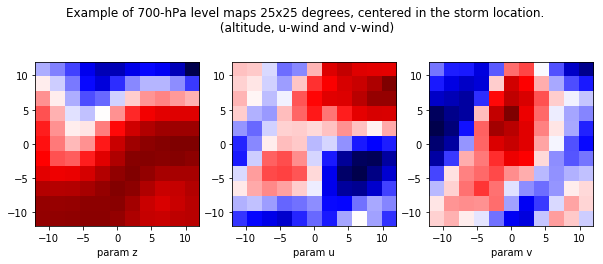

In [42]:
params_25x25=['z','u','v']
plt.figure(figsize=(10,4))
for p,param in enumerate(params_25x25):
    image=np.zeros([grid_l,grid_l])
    for i in range(grid_l):
         for j in range(grid_l):
            image[i,j]=data_train[param+'_'+str(i)+'_'+str(j)][sample_id]
    plt.subplot(1,3,p+1)
    plt.imshow(np.array(image),extent=[-12,12,-12,12],
               interpolation='nearest', origin='lower', cmap='seismic')
    plt.xlabel('param '+param)
t=plt.suptitle('Example of 700-hPa level maps 25x25 degrees, centered in the storm location.'
         +'\n (altitude, u-wind and v-wind)')

#### b) 11x11 degree sst, slp, humidity at 1000hPa,  and vorticity at 700hPa
We provide some more localized maps of 11 x 11 degrees (lat/long) at the surface: the sea surface temperature `sst`, surface level pressure `slp`, the relative humidity `hum` at 1000hPa (near surface). These grids are sampled to 11x11 pixels (1 pixel = 1 degree). We also provide the vorticity at 700hPa `vo700`. 

NB: `sst` is only defined on the sea, so land has NaNs values.

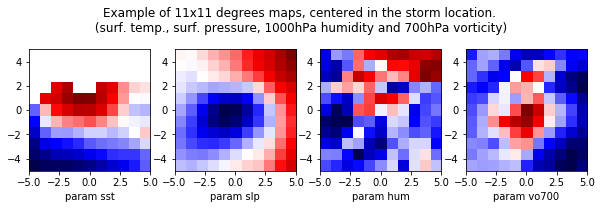

In [44]:
params_11x11=['sst','slp','hum','vo700']
plt.figure(figsize=(10,3))
for p,param in enumerate(params_11x11):
    image=np.zeros([grid_l,grid_l])
    for i in range(grid_l):
         for j in range(grid_l):
            image[i,j]=data_train[param+'_'+str(i)+'_'+str(j)][sample_id]
    plt.subplot(1,4,p+1)
    plt.imshow(np.array(image),extent=[-5,5,-5,5],
               interpolation='nearest', origin='lower', cmap='seismic')
    plt.xlabel('param '+param)
t=plt.suptitle('Example of 11x11 degrees maps, centered in the storm location.'
         +'\n (surf. temp., surf. pressure, 1000hPa humidity and 700hPa vorticity)')

## The pipeline

<img src="https://github.com/sophiegif/ramp_kit_storm_forecast_new/blob/master/figures_pynb/pipeline.png?raw=true" width="70%">

For submitting at the [RAMP site](http://ramp.studio), you will have to write two classes, saved in a specific file:   

* a class `FeatureExtractor` in a `feature_extractor.py` file.
* a class `Regressor` in a `regressor.py` file.

You can look at the simple examples provided in /submissions:
- starting_kit : using only the track data
- starting_kit_pressure_map : using both track data and image data

### Using data from previous time steps
Of course, you can use the data from previous time steps, e.g., for the prediction of the intensity of storm S at t=3 you can use data from S at t=\[0:2\]. However, it is completely forbidden (and we check it!) to use future data like S at t=4,.. This is illustrated in the figure below, where the estimation of the 24h-forecast of the time instant 2 (red line) can use blue but not red features.

- `illegal_lookahead`: this simple submission illustrates the error you will have if you are illegally looking ahead time of the same storm.
- `legal_lookbefore` : this simple submission illustrates how to use information from previous time steps of the same storm.

<img src="https://github.com/sophiegif/ramp_kit_storm_forecast_new/blob/master/figures_pynb/illegal_lookahead.png?raw=true" width="70%">
<div style="text-align: center">Data from previous steps are allowed, but data from future steps are forbidden.</div>

## Evaluation
The framework is evaluated with a cross-validation approach. The metric used is the RMSE (root mean square error) in knots across all storm time instants. We also made visible three other metrics: `mae` is the mean absolute error, in knots. `mae_hurr` is the MAE using only time instants corresponding to hurricanes (windspeed>64 knots), while `rel_mae_hurr` is the relative RMSE on hurricanes. These metrics are interesting because the current forecasting practice is to exclude all other stages of development (e.g., extratropical, tropical wave...), see [this page](https://www.nhc.noaa.gov/verification/verify5.shtml?).

## Testing the submission
You can test locally our pipeline using `ramp_test_submission` command line (`-h` will give you all infos). For that, open a terminal in your `storm_forecast/` folder and type on a terminal `ramp_test_submission --submission starting_kit`. You can then copy a submission example in `submissions/<YOUR_SUBMISSION_NAME>/`and modify its codes as you want. Finally, test it on your computer with `ramp_test_submission --submission <YOUR_SUBMISSION_NAME>`.

If you get to see the train and test scores, and no errors, then you can submit your model to the ramp.studio.

## Some warnings when building the model

<div class="alert alert-danger">

 <ul>
  <li>If you want to use the features from previous time steps in your learning (for example using LSTMs), you will have to use the 'stormid' and the 'instant_t' columns. Moreover, you will have to handle separetly the first time steps, which are not provided with past data.</li>
  <li>The intensity value to predict is the max windspeed. However, this value was measured empirically with a precision of ~5knots. </li>
</ul> 

</div>

## Submitting to the online challenge: ramp.studio

Once you have found a good model, you can submit them to [ramp.studio](http://www.ramp.studio) to enter the online challenge. First, if it is your first time using the RAMP platform, [sign up](http://www.ramp.studio/sign_up), otherwise [log in](http://www.ramp.studio/login). Then sign up to the event [storm_forecast_CI2018](http://www.ramp.studio/events/storm_forecast_CI2018). Sign up for the event. Both signups are controled by RAMP administrators, so there **can be a delay between asking for signup and being able to submit**.

Once your signup request is accepted, you can go to your [sandbox](http://www.ramp.studio/events/storm_forecast_CI2018/sandbox) and copy-paste (or upload) [`feature_extractor.py`](/edit/submissions/starting_kit/feature_extractor.py) and [`classifier.py`](/edit/submissions/starting_kit/classifier.py). Save it, rename it, then submit it. The submission is trained and tested on our backend in the similar way as `ramp_test_submission` does it locally. While your submission is waiting in the queue and being trained, you can find it in the "New submissions (pending training)" table in [my submissions](http://www.ramp.studio/events/storm_forecast_CI2018/my_submissions). Once it is trained your submission shows up on the [public leaderboard](http://www.ramp.studio/events/storm_forecast_CI2018/leaderboard). 
If there is an error (despite having tested your submission locally with `ramp_test_submission`), it will show up in the "Failed submissions" table in [my submissions](http://www.ramp.studio/events/storm_forecast_CI2018/my_submissions). You can click on the error to see part of the trace.

After submission, do not forget to give credit to the previous submissions you reused or integrated into your submission.

The data set we use on the backend is usually different from what you find in the starting kit, so the score may be different.

The official score in this RAMP (the first score column after "historical contributivity" on the [leaderboard](http://www.ramp.studio/events/storm_forecast_CI2018/leaderboard)) is the RMSE.

## More information

You can find more information in the [README](https://github.com/paris-saclay-cds/ramp-workflow/blob/master/README.md) of the [ramp-workflow library](https://github.com/paris-saclay-cds/ramp-workflow).

## Contact

Don't hesitate to [contact us](mailto:admin@ramp.studio?subject=Storm forecast CI2018 ramp).